# C3S_422_Lot2 Marine, Coastal and Fisheries Sectoral Information Systems

## NEMO- and POLCOMS-ERSEM

The NEMO- and POLCOMS-ERSEM models compute and save several indicators that can be analysed and plotted directly with little or no need for further post-processing of the model outputs. Examples include sea water potential temperature and salinity. Other indicators are generated in post-processing. Some of these are computationally expensive to calculate, and do not lend themselves to customisation. Hence, these have been pre-calculated before being added to the CDS catalogue. Examples include the potential energy anomaly and apparent oxygen utilisation from POLCOMS-ERSEM. Lastly, there are a small number of indicators that lend themselves to production during interactive post-processing, allowing users to customise input parameters. Examples include the duration of the phytoplankton growing season, winter nutrient concenrtations and the minimum concentration of bottom oxygen.

This example notebook mainly shows how the indicators that require some form of post-processing may be calculated and plotted.

Dr. James Clark, PML, 2019

In [1]:

%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
import xarray
import cmocean

In [2]:
import zipfile as zip
import tempfile
import cdsapi
import netCDF4 as nc

In [3]:
indicator = "thetao"
rcp = "rcp45"
year = "2006"
month = "01"
file_name = "NEMO_ERSEM_biogeochemical-monthly-all-{}-{}-{}-{}-v1.1.nc".format(rcp,indicator,year,month)
root_nemo_dir = 'NEMO_ERSEM_biogeochemical'
curl_cmd = "curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/monthly/all/rcp45/{}/{}/{} --output {}/{}".format(year, month, file_name, root_nemo_dir, file_name)
!mkdir -p $root_nemo_dir

!$curl_cmd 
print(curl_cmd)
    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.0M  100 13.0M    0     0  39.4M      0 --:--:-- --:--:-- --:--:-- 39.4M
curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/monthly/all/rcp45/2006/01/NEMO_ERSEM_biogeochemical-monthly-all-rcp45-thetao-2006-01-v1.1.nc --output NEMO_ERSEM_biogeochemical/NEMO_ERSEM_biogeochemical-monthly-all-rcp45-thetao-2006-01-v1.1.nc


## Example 1 - Sea water potential temperature

To begin, we look at an indicator that can be extracted from the CDS and plotted directly: sea water potential temperature. Sea water potential temperature is simulated directly by the underlying hydrodynamic model, which in this case is either NEMO or POLCOMS. Below, the monthly mean sea surface temperature for January 2006 under RCP4.5 is plotted using NEMO-ERSEM simulation outputs:

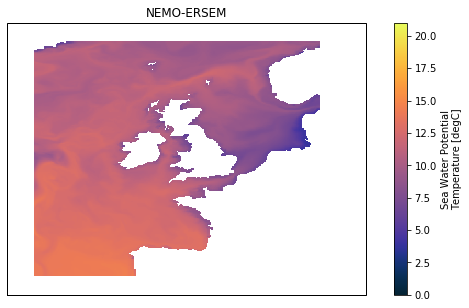

In [4]:
# NEMO-ERSEM data file
nemo_file = '{}/NEMO_ERSEM_biogeochemical-monthly-all-rcp45-thetao-2006-01-v1.1.nc'.format(root_nemo_dir)
nemo_ds = xarray.open_dataset(nemo_file)

fig, ax_nemo = plt.subplots(1, 1, figsize=(10,5), subplot_kw={'projection': cartopy.crs.Mercator()})
nemo_plot = nemo_ds['thetao'].isel(time=0, depth=0).plot.pcolormesh(ax=ax_nemo, vmin=0, vmax=21,
                                                                    cmap=cmocean.cm.thermal,
                                                                    add_colorbar=True);

ax_nemo.set_title('NEMO-ERSEM');

## Example 2 - Potential energy anomaly

Stratification indices describe the extent to which vertical mixing is suppressed. The potential energy anomaly is a quantitative measure of stratification that represents the work required to bring about complete mixing of a column of water down to a specified depth. The higher the potential energy anomaly, the more stratified the water column. A potential energy anomaly of zero is indicative of a fully mixed water column. The potential energy anomaly is derived from the density field, which in turn is a function of temperature and salinity. Here, it has been pre-calculated on a monthly basis, meaning it can be plotted directly without any need for further post-processing, just as the temperature field was. The following code plots the potential energy anomaly using NEMO-ERSEM simulations outputs for August 2006, a time when the water column across large areas of the the Northwest European Shelf is stratified:

In [5]:
indicator = "pea"
month = "08"
file_name = "NEMO_ERSEM_biogeochemical-monthly-integrated-{}-{}-{}-{}-v1.1.nc".format(rcp,indicator,year,month)
curl_cmd = "curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/monthly/integrated/rcp45/{}/{}/{} --output {}/{}".format(year, month, file_name, root_nemo_dir, file_name)
!$curl_cmd 
print(curl_cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  244k  100  244k    0     0  4534k      0 --:--:-- --:--:-- --:--:-- 4534k
curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/monthly/integrated/rcp45/2006/08/NEMO_ERSEM_biogeochemical-monthly-integrated-rcp45-pea-2006-08-v1.1.nc --output NEMO_ERSEM_biogeochemical/NEMO_ERSEM_biogeochemical-monthly-integrated-rcp45-pea-2006-08-v1.1.nc


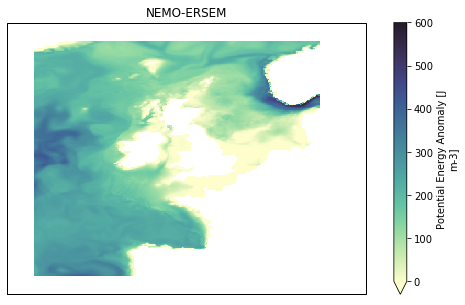

In [6]:
# NEMO-ERSEM data file
nemo_file = '{}/{}'.format(root_nemo_dir, file_name)
nemo_ds = xarray.open_dataset(nemo_file)

# Plot NEMO-ERSEM data
fig, ax_nemo = plt.subplots(1, 1, figsize=(10,5), subplot_kw={'projection': cartopy.crs.Mercator()})
nemo_plot = nemo_ds['pea'].isel(time=0).plot.pcolormesh(ax=ax_nemo, vmin=0, vmax=600,
                                                           cmap=cmocean.cm.deep,
                                                           add_colorbar=True);

ax_nemo.set_title('NEMO-ERSEM');

## Example 3 - Winter nutrient concentrations

One application of the nutrient data is to calculate winter nutrient concentrations, which are often used as an indicator for eutrophication. Winter nutrient concentrations are easily calculated using monthly nutrient concentrations, and are thus not provided directly within the CDS. The following code is a relatively simple example of a post-processing step which can be used to generate an important indicator for eutrophication status.

Here we calcualte winter phosphate concentrations from NEMO-ERSEM for the year 2006 by taking the average concentration over the months of January, February, November and December of the same year. The methodology is in keeping with that adopted by OSPAR:

In [7]:
indicator = "po4"
months = ['01', '02', '11', '12']
for month in months:
    file_name = "NEMO_ERSEM_biogeochemical-monthly-all-{}-{}-{}-{}-v1.1.nc".format(rcp,indicator,year,month)
    curl_cmd = "curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/monthly/all/rcp45/{}/{}/{} --output {}/{}".format(year, month, file_name, root_nemo_dir, file_name)
    !$curl_cmd 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.3M  100 13.3M    0     0  47.0M      0 --:--:-- --:--:-- --:--:-- 47.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.3M  100 13.3M    0     0  53.9M      0 --:--:-- --:--:-- --:--:-- 53.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.4M  100 13.4M    0     0  44.8M      0 --:--:-- --:--:-- --:--:-- 44.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.3M  100 13.3M    0     0  38.4M      0 --:--:-- --:--:-- --:--:-- 38.3M


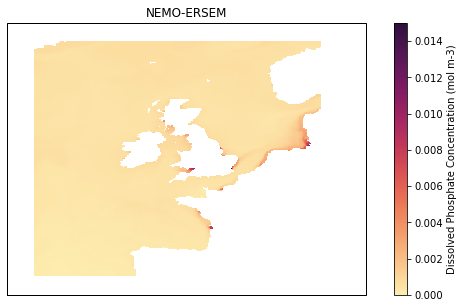

In [8]:
import glob

# Calculate average concentration
conc = None
for month in months:
    nemo_file = "{}/NEMO_ERSEM_biogeochemical-monthly-all-{}-{}-{}-{}-v1.1.nc".format(root_nemo_dir, rcp,indicator,year,month)
    nemo_ds = xarray.open_dataset(nemo_file)

    if conc is not None:
        conc = conc + nemo_ds[indicator].values
    else:
        conc = nemo_ds[indicator].values
        lons = nemo_ds['longitude'].values
        lats = nemo_ds['latitude'].values
        long_name = nemo_ds[indicator].long_name
        units = nemo_ds[indicator].units

    nemo_ds.close()

conc = conc / len(months)

# Plot NEMO-ERSEM data
fig, ax_nemo = plt.subplots(1, 1, figsize=(10,5), subplot_kw={'projection': cartopy.crs.Mercator()})
nemo_plot = ax_nemo.pcolormesh(lons, lats, conc[0,0,:], vmin=0, vmax=0.015,
                           cmap=cmocean.cm.matter);
cbar = fig.colorbar(nemo_plot)
cbar.set_label('{} ({})'.format(long_name, units))

ax_nemo.set_title('NEMO-ERSEM');

## Example 4 - Bottom oxygen concentrations

Bottom oxygen concentrations are another OSPAR indicator for eutrophication status. Oxygen is included as a state variable within ERSEM, and it is possible to plot bottom oxygen concentrations using the model output fields. This requires a small number of extra processing steps, which are put in place to extract near sea floor concentrations from a grid with spatially varying bathymetry.

Here we extract the minimum daily mean concentration from the near sea floor field for the month of August 2006; which, as shown above, is a time when large areas of the Northwest European Shelf are stratified. Under stratified conditions, ventialation of bottom waters is restricted, and oxygen consumption by respiration can drive oxygen concentrations down to sub-lethal or even lethal concentrations for aerobic organisms such as fish and shell fish. We plot the minimum daily mean concentration, as opposed to the monthly mean concentration, since even short-term exposures to low oxygen conditions can be a serious cause for concern:

In [9]:
indicator = "o2"
month = "08"
file_name = "NEMO_ERSEM_biogeochemical-daily-all-{}-{}-{}-{}-v1.1.nc".format(rcp,indicator,year,month)
curl_cmd = "curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/daily/all/rcp45/{}/{}/{} --output {}/{}".format(year, month, file_name, root_nemo_dir, file_name)
!$curl_cmd 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  368M  100  368M    0     0  87.2M      0  0:00:04  0:00:04 --:--:-- 87.2M


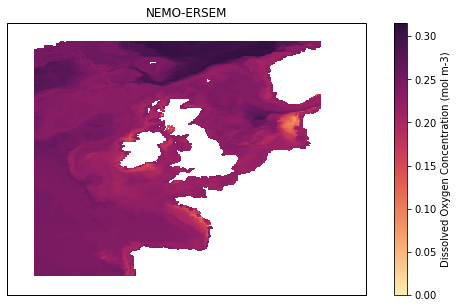

In [10]:
# Helper function that are used to extract near bottom values
from cdslibs import ersem_tools

# NEMO-ERSEM data file
nemo_file = '{}/{}'.format(root_nemo_dir, file_name)
nemo_ds = xarray.open_dataset(nemo_file)

# For plotting
lons = nemo_ds['longitude'].values
lats = nemo_ds['latitude'].values
long_name = nemo_ds['o2'].long_name
units = nemo_ds['o2'].units

# First, convert to a masked array, then extract near bottom values only
o2 = nemo_ds.o2.to_masked_array()
bottom_o2 = ersem_tools.bottom_var(o2)

# Computer daily minimum values
daily_minimum_bottom_o2 = bottom_o2.min(axis=0)

# Plot NEMO-ERSEM data
fig, ax_nemo = plt.subplots(1, 1, figsize=(10,5), subplot_kw={'projection': cartopy.crs.Mercator()})
nemo_plot = ax_nemo.pcolormesh(lons, lats, daily_minimum_bottom_o2, vmin=0, vmax=None,
                           cmap=cmocean.cm.matter);
cbar = fig.colorbar(nemo_plot)
cbar.set_label('{} ({})'.format(long_name, units))

ax_nemo.set_title('NEMO-ERSEM');

From the plot, it can be seen the lowest oxygen concentrations are found in and around the German Bight. Historically, this area has been observed to be particularly susceptible to experiencing low oxygen concentrations.

## Example 5 - Phytoplankton growing season

The last indicator we examine here, which also requires an element of post-processing, is the length of the phytoplankton growing season, which we calculate using surface chlorophyll concentration. While more sophisticated approaches to calculating the length of the phytoplankton growing season exist in the literature (e.g. Racault et al 2017), here we adopt a relatively simple approach which calculates the length of the phytoplankton growing season based on the number of days on a per pixel basis over which the concentration of chlorophyll-a is above a given threshold value. We calculate the threshold concentration based on the median value of chlorophyll-a over a given time window, plus a small percentage (here taken to b 5%). The approach is demonstrated using daily data for a single year (2006).

### References

Racault, M.-F., Sathyendranath, S., Menon, N., Platt. T. (2017b) Phenological responses to ENSO in the global oceans. Surveys in Geophysics, 38: 277. doi:10.1007/s10712-016-9391-1


In [15]:
indicator = "chl"
year = '2006'
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for month in months:
    file_name = "NEMO_ERSEM_biogeochemical-daily-all-{}-{}-{}-{}-v1.1.nc".format(rcp,indicator,year,month)
    curl_cmd = "curl http://eu-fisheries.copernicus-climate.eu/NEMO_ERSEM_biogeochemical/daily/all/rcp45/{}/{}/{} --output {}/{}".format(year, month, file_name, root_nemo_dir, file_name)
    !$curl_cmd 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  375M  100  375M    0     0  51.7M      0  0:00:07  0:00:07 --:--:-- 54.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  45.5M      0  0:00:07  0:00:07 --:--:-- 42.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  380M  100  380M    0     0  54.6M      0  0:00:06  0:00:06 --:--:-- 56.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  368M  100  368M    0     0  70.7M      0  0:00:05  0:00:05 --:--:-- 73.1M
  % Total    % Received % Xferd  Average Speed   Tim

/home/jovyan/work/python_libs/cdslibs/ersem_tools.py:198: RuntimeWarning: invalid value encountered in greater
  indices = np.where(surface_chlorophyll[i] > threshold)


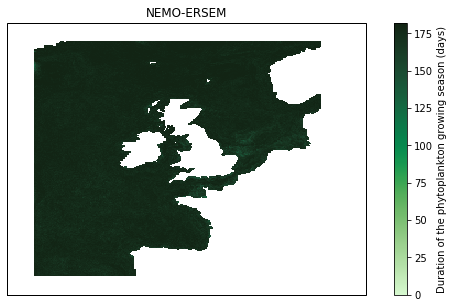

In [17]:
import glob

# Helper functions
from cdslibs import ersem_tools as et
#from ersem_tools import calculate_phytoplankton_growing_season_threshold
#from ersem_tools import calculate_phytoplankton_growing_season_length

# Calculate average concentration
conc = None
for month in months:
    nemo_file = "{}/NEMO_ERSEM_biogeochemical-daily-all-{}-{}-{}-{}-v1.1.nc".format(root_nemo_dir, rcp,indicator,year,month)
    nemo_ds = xarray.open_dataset(nemo_file)

    if conc is not None:
        monthly_conc = nemo_ds[indicator].isel(depth=0).values
        
        conc = np.concatenate((conc, monthly_conc), axis=0)
    else:
        conc = nemo_ds[indicator].isel(depth=0).values
        lons = nemo_ds['longitude'].values
        lats = nemo_ds['latitude'].values

    nemo_ds.close()

# Mask land points
conc = np.ma.masked_invalid(conc)
    
# Compute the threshold concentration
threshold = et.calculate_phytoplankton_growing_season_threshold(conc)
    
# Compute the length of the phytoplankton growing season using the daily data
duration = et.calculate_phytoplankton_growing_season_length(conc, threshold, delta_t=1.0)

# Plot NEMO-ERSEM data
fig, ax_nemo = plt.subplots(1, 1, figsize=(10,5), subplot_kw={'projection': cartopy.crs.Mercator()})
nemo_plot = ax_nemo.pcolormesh(lons, lats, duration, vmin=0, vmax=None,
                               cmap=cmocean.cm.algae);
cbar = fig.colorbar(nemo_plot)
cbar.set_label('Duration of the phytoplankton growing season (days)')

ax_nemo.set_title('NEMO-ERSEM');